In [1]:
using DifferentialEquations, DiffEqCallbacks, LinearAlgebra, Plots, Interact

In [2]:
# Define constants 
eps0 = 8.8541878128e-12 ;
mu0 = 1.256637062e-6;
c0 = 1/sqrt(eps0*mu0);
imp0 = sqrt(mu0/eps0);
Q_factor = 1e9;

center_wavelength = 1550e-9;
omega0 = 2 * π * c0/center_wavelength;
pulse_width = 10e-15;
pulse_delay = 4 * pulse_width;

Playing around with the signal function solving a driven CMT system

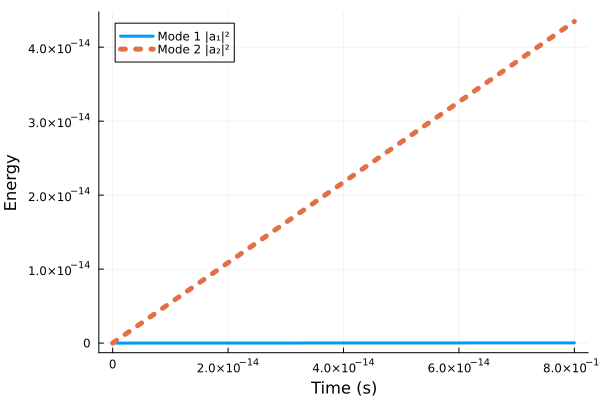

In [3]:
#Define the input guassian signal 
function signal(t; delay=pulse_delay, width=pulse_width, ω=omega0)
    exp(-((t-delay)/width)^2) * sin(ω*t)
end

# Physics and coupling parameters
ω, κ = 2π*pulse_width, 1.0
γ = 1e13

# Define the CMT ODE du/dt = f(u, p, t) function
function driven_cmt!(du, u, p, t)
    ω, κ, γ = p
    s = signal(t) # external drive
    # mode 1: self-oscillation + coupling + input
    du[1] = (1im*ω - γ/2) * u[1] + 1im*κ*u[2] + sqrt(γ)*s
    # mode 2: self-oscillation + coupling
    du[2] = (1im*ω - γ/2)*u[2] + 1im*κ*u[1] + sqrt(γ)
end 

# Initial condition and parameters
u0 = ComplexF64[0.0 + 0im, 0.0 + 0im] # start with no energy
E0 = real(dot(conj(u0), u0)) 
p = (ω, κ, γ)
t_end = pulse_delay + 4 * pulse_width
tspan = (0.0,t_end)

# solve
prob = ODEProblem(driven_cmt!, u0, tspan, p)
sol = solve(prob, Tsit5())

# Extract time points and mode amplitudes
ts = sol.t
a1 = [u[1] for u in sol.u]
a2 = [u[2] for u in sol.u]

plot(ts, abs2.(a1), label="Mode 1 |a₁|²", xlabel="Time (s)", ylabel="Energy",lw=3)
plot!(ts, abs2.(a2), label="Mode 2 |a₂|²", ls =:dot,lw=5)


This section will attempt to model the nonlinear equation: Bistability CMT

In [4]:
# Bistable TCMT ODE
function TMCT_bi!(du, u, p, t)
    s = signal(t)
    ω, α, τ = p # resonance, Kerr coeff, lifetime

    du[1] = -1im*(ω - α*abs2(u[1]))*u[1] - (2/τ)*u[1] + sqrt(2/τ)*s
end

TMCT_bi! (generic function with 1 method)

Set up the ODE problem and solver

In [5]:
u0 = ComplexF64[0.0+0im]
ω0 = 2π*1e14
α = 1e3
τ = 1e-13
p = (ω0, α, τ)
tspan = (0.0, 1e-12)

prob = ODEProblem(TMCT_bi!, u0, tspan, p)
sol = solve(prob, Tsit5(); dt=1e-16, saveat=1e-15)
times = sol.t 
u_vals = [u[1] for u in sol.u];

Intracavity Energy |u|² vs. time

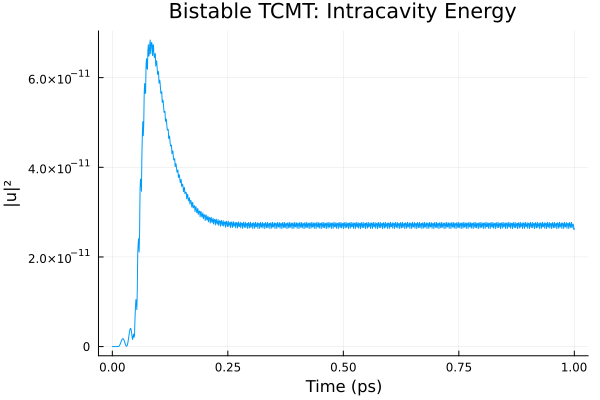

In [17]:
engplot = plot(
    times .* 1e12, 
    abs2.(u_vals),
    xlabel="Time (ps)",
    ylabel="|u|²",
    title="Bistable TCMT: Intracavity Energy",
    legend=false
)

display(engplot)

Real and Imaginary Components vs. Time


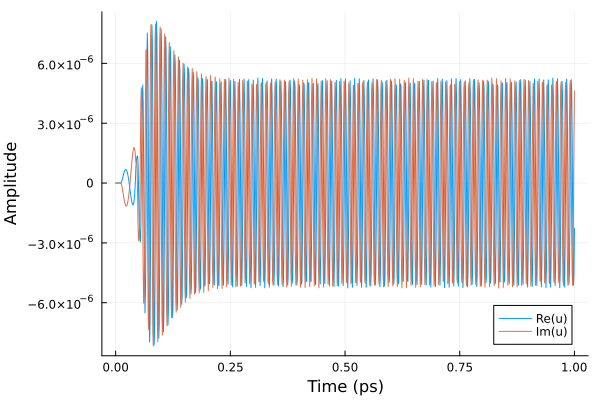

In [16]:
plot(
    times .* 1e12,
    real.(u_vals),
    label="Re(u)"
)
p1 = plot!(times .* 1e12, imag.(u_vals), label="Im(u)", xlabel="Time (ps)", ylabel="Amplitude")

display(p1)

Phase-Space Plot

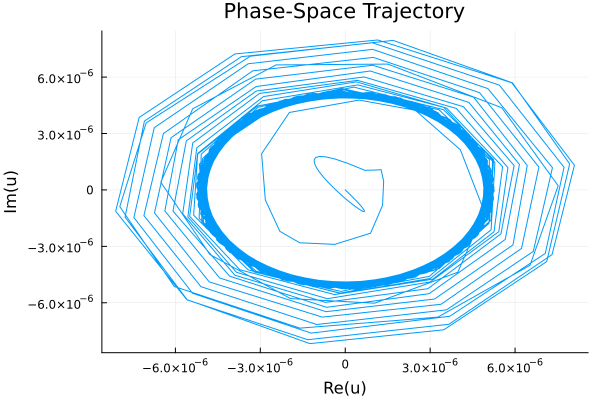

In [15]:
p2 = plot(real.(u_vals), imag.(u_vals), xlabel="Re(u)", ylabel="Im(u)", title="Phase-Space Trajectory", legend=false)
display(p2)

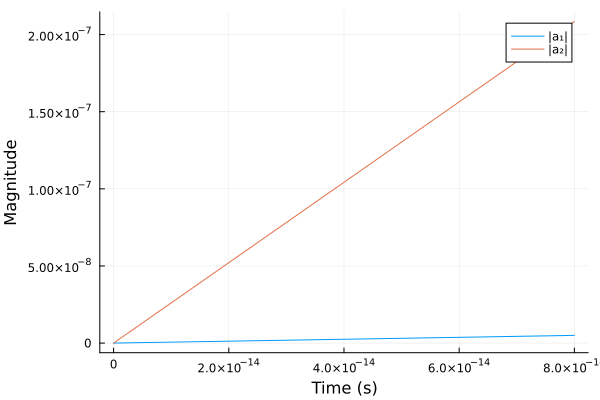

In [14]:
# Plot magnitdues vs time
plot(ts,
     abs.(a1),
     label="|a₁|",
     xlabel="Time (s)",
     ylabel="Magnitude",
     legend=:topright
)
plotmag = plot!(ts,
      abs.(a2),
      label="|a₂|"
)

display(plotmag)

Mapping out the bistable responsed curve by sweeping the drive strength S up and then back down. Plotting SST intracavity energy |u|² vs. S

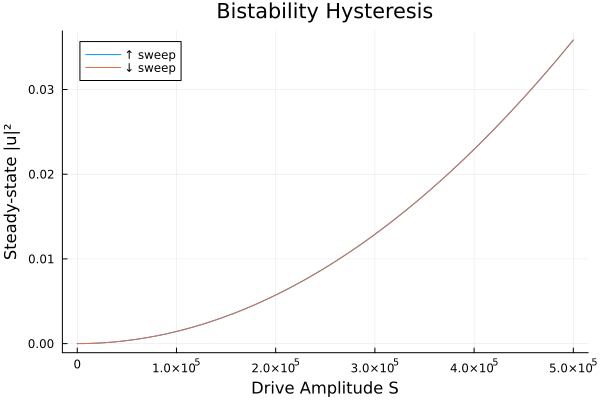

In [13]:
#Rotating-frame single mode bistable TCMT ODE
function bifur!(du, u, p, t)
    Δ, α, τ, S = p
    du[1] = -1(1/τ + 1im*Δ)*u[1] - 1im*α*abs2(u[1])*u[1]+sqrt(2/τ)*S
end

#Fixed parameters
Δ = 2π*1e12 # detuning [rad/s]
α = 1e3 # Kerr coefficient
τ = 1e-13 # photon lifetime [s]
tspan = (0.0, 5e-10) #long enough to reach steady state
u0 = ComplexF64[0.0]

# Sweep drive S ↑ then ↓
Smax = 5e5
npts = 80
Ss = range(0, Smax; length=npts)

energies_up = Float64[]
energies_down = Float64[]

# Looping through ascending S
for S in Ss 
    p = (Δ, α,τ, S)
    prob = ODEProblem(bifur!, u0, tspan, p)
    sol = solve(prob, Tsit5(); reltol=1e-8, abstol=1e-8)
    push!(energies_up, abs2(sol.u[end][1]))
    u0[1] = sol.u[end][1]
end

for S in reverse(Ss)
    p = (Δ, α,τ, S)
    prob = ODEProblem(bifur!, u0, tspan, p)
    sol = solve(prob, Tsit5(); reltol=1e-8, abstol=1e-8)
    push!(energies_down, abs2(sol.u[end][1]))
    u0[1] = sol.u[end][1]
end

plot(Ss, energies_up; label="↑ sweep", xlabel="Drive Amplitude S", ylabel="Steady-state |u|²", title="Bistability Hysteresis", legend=:topleft)
biplot = plot!(Ss, reverse(energies_down); label="↓ sweep")

display(biplot)
